# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)


Using PyTorch version: 2.0.0+cpu  Device: cpu


## 3. CIFAR10 Data Normalization and Augmentation

In [3]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


문제) 학습 데이터(training data)의 색상별 평균과 표준 편차를 구하자.


In [4]:
print(train_data.data.shape)
print(train_data.data.mean(axis=(0, 1, 2)) / 255)
print(train_data.data.std(axis=(0, 1, 2)) / 255)
    

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


문제) 위 내용을 반영하여 데이터를 Normalize 하고 랜덤하게 좌우반전 및 흑백 사진으로 바꾸자.

In [5]:
transform = transforms.Compose(
    [
        transforms.RandomApply([transforms.RandomGrayscale(),transforms.RandomHorizontalFlip()],p=0.6),
        transforms.ToTensor(),
        transforms.Normalize([(train_data.data.mean(axis=(0, 1, 2)) / 255)[0], 
                              (train_data.data.mean(axis=(0, 1, 2)) / 255)[1], 
                              (train_data.data.mean(axis=(0, 1, 2)) / 255)[2]], 
                             [(train_data.data.std(axis=(0, 1, 2)) / 255)[0], 
                              (train_data.data.std(axis=(0, 1, 2)) / 255)[1], 
                              (train_data.data.std(axis=(0, 1, 2)) / 255)[2]])
    ])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


완성된 dataset.CIFAR10 객체를 train_loader에 넣는다.

In [6]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)


아래의 코드를 여러번 돌려, 실제로 좌우반전 및 흑백사진으로 변하는지 확인하자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


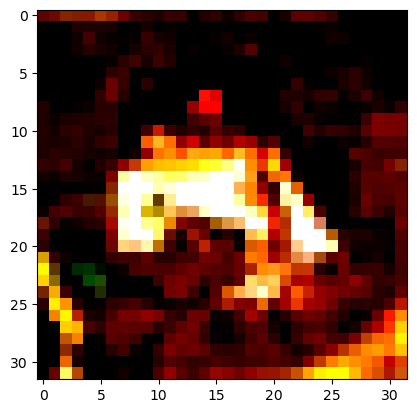

In [7]:
for (X_train, y_train) in train_loader:
    plt.imshow(X_train[0].permute(1,2,0).numpy())
    plt.show()
    break
    

## 4. torch.nn을 이용하여 모델-1 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Batch Normalization 을 사용할 것

In [8]:
import torch.nn as nn

class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.L1 = torch.nn.Linear(3*32*32, 100)
        self.bn = torch.nn.BatchNorm1d(100)
        self.relu = torch.nn.ReLU()
        self.L2 = torch.nn.Linear(100, 10)

        
    def forward(self,x):
        ih = self.L1(x)
        bn = self.bn(ih)
        relu = self.relu(bn)
        ho = self.L2(relu)
        x = ho
        return x

## 5. torch.nn을 이용하여 모델-2 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Dropout을 확률을 50%로 사용할 것 - BN는 사용하지 말것!

In [9]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.L1 = torch.nn.Linear(32*32*3, 100)
        self.dropout = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU()
        self.L2 = torch.nn.Linear(100, 10)
        
    def forward(self,x):
        ih = self.L1(x)
        relu = self.relu(ih)
        dropout = self.dropout(relu)
        ho = self.L2(dropout)
        x = ho
        return x

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [10]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, -1) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = torch.reshape(image,(batch_size, -1))

        # Forward propagration 계산하기.
        outputs = network(image)
        
        # loss_func 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = outputs.data.argmax(dim=1)
        train_correct += pred.eq(label).sum()

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [11]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = torch.reshape(image,(batch_size, -1))

            # Forward propagration 계산하기.
            outputs = network(image)
            
            # loss_func 함수를 적용하여 loss를 구하고 저장하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = outputs.data.argmax(dim=1)
            correct += pred.eq(label).sum()


        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

1. SGD Optimizer를 사용하고

2. Regularizer 를 사용하여 (weight_decay = 0.01로 사용할 것)

학습시키기

In [12]:
def training(network, learning_rate = 0.01):
    
#     learning_rate = 0.01
    epoches = 20
    
    cls_loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate, weight_decay = 0.01)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [13]:
network = Model_1()
rlt_const = training(network)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.405674
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.865151
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.792284
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.962816

Training set: Accuracy: 19158/50000 (38%)
Test set: Accuracy: 4331/10000 (43%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.802547
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.669029
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.764280
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.943860

Training set: Accuracy: 21594/50000 (43%)
Test set: Accuracy: 4544/10000 (45%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.835994
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.580304
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.623491
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.894595

Training set: Accuracy: 22466/50000 (45%)
Test set: Accuracy: 4652/10000 (47%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.757117
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.635528
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.658340
Train Epoch: 3 [48000/50000

In [14]:
network2 = Model_2()
rlt_const2 = training(network2, 0.05)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.250974
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.031513
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.932210
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.271713

Training set: Accuracy: 15246/50000 (30%)
Test set: Accuracy: 3565/10000 (36%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.843902
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.807654
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.031282
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.295078

Training set: Accuracy: 15982/50000 (32%)
Test set: Accuracy: 3618/10000 (36%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.865587
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.870821
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.900439
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.424363

Training set: Accuracy: 16333/50000 (33%)
Test set: Accuracy: 3750/10000 (38%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.976424
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.942910
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.730792
Train Epoch: 3 [48000/50000

# 8.학습 결과 보기 
## loss와 Accuracy 값 비교

In [15]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

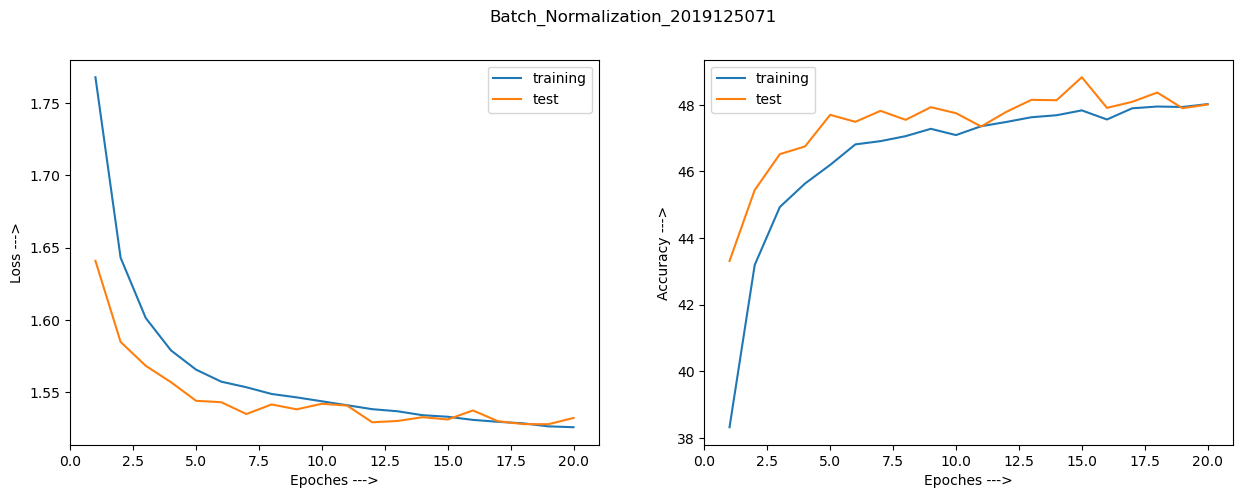

In [17]:
show_rlt(rlt_const, 'Batch_Normalization_2019125071')

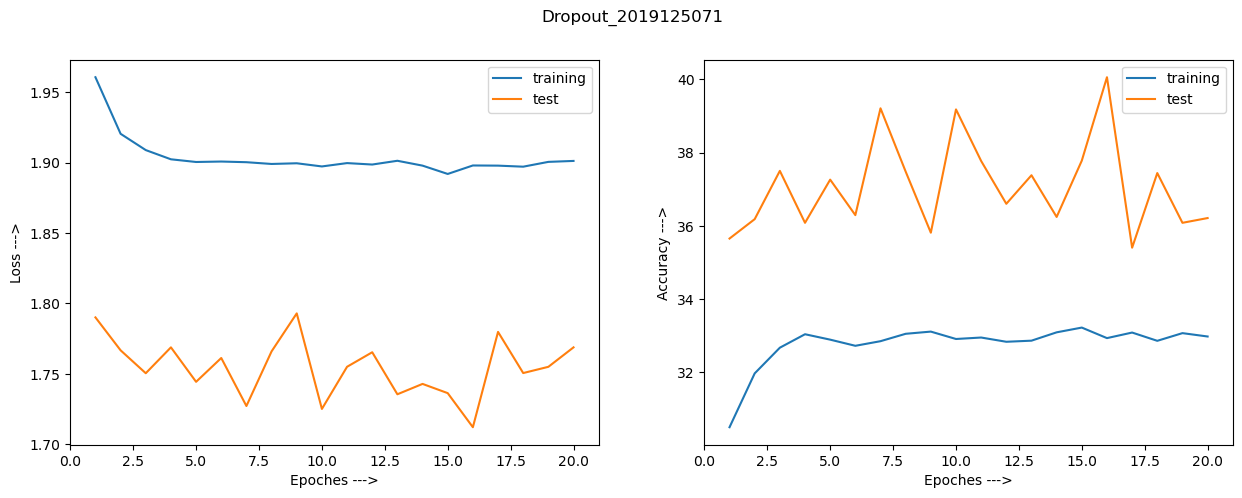

In [18]:
show_rlt(rlt_const2, 'Dropout_2019125071')

# 9. Hyperparameter 찾기

위 Dropout 모델의 최적의 learning rate를 찾으세요.

스스로 계획을 짜고 어떤 lr 이 가장 나은 성능을 내었는지 분석하세요.

learning rate를 0.0001~1사이에서 Random Search를 사용해서 최적값을 구하는 시도를 했다.
1번째 시도: learning rate = [0.0001, 0.005, 0.01, 0.3] => Accuracy = [39, 49, 48, NaN]
2번째 시도: learning rate = [0.001, 0.003, 0.007, 0.009] => Accuracy = [47, 48, 49, 48] 
3번째 시도: learning rate = [0.0055, 0.006, 0.0065] => Accuracy = [49, 49, 49]
    =>learning rate가 0.5~0.7사이의 값으로 설정되었을 때 가장 나은 성능을 보였다.